In [2]:
# importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# converting salida.shw into a dataframe
COLS = ["CorsikaId","px","py","pz","xprime","yprime","t",
        "shower_id","prm_id","prm_energy","prm_theta","prm_phi"] # setting this as the column names

df = pd.read_csv("salida.shw", # path
                 comment="#", # ignore comments
                 sep=' ',# separation is space
                 header=None, # no other header set
                 names=COLS, # the name of the columns
                 engine="python"
)

In [3]:
# subsetting the data 
muons = (df["CorsikaId"] == 5) | (df["CorsikaId"] == 6)
df = df[muons]

In [4]:
# resetting index
df = df.reset_index()

In [5]:
df['p'] = np.sqrt(df['px']**2 + df['py']**2 + df['pz']**2)
df['theta_rad'] = np.arccos(df['pz'] / df['p'])  # zenith angle in radians 

In [6]:
# creating a new column to store the zenith angle in degrees
df['theta'] = np.rad2deg(df['theta_rad'])

In [7]:
# generating the bins from 0 to 90 stepping by 10 (degrees)
bins = np.arange(0, 91, 10)
print(bins)

[ 0 10 20 30 40 50 60 70 80 90]


In [8]:
# Counting how many muons fall in each 10 degree interval
counts, bin_edges = np.histogram(df['theta'], bins=bins)

In [9]:
#computing  the bin centres midpoint
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
print(bin_centers)

[ 5. 15. 25. 35. 45. 55. 65. 75. 85.]


In [10]:
# converting bin edges to radians since np.cos works with radians
bin_edges_rad = np.deg2rad(bin_edges)
print(bin_edges)
print()
print(bin_edges_rad)

[ 0 10 20 30 40 50 60 70 80 90]

[0.         0.17453293 0.34906585 0.52359878 0.6981317  0.87266463
 1.04719755 1.22173048 1.3962634  1.57079633]


In [11]:
solid_angles = 2 * np.pi * (np.cos(bin_edges_rad[:-1]) - np.cos(bin_edges_rad[1:]))

In [12]:
time = 1 # using the total run time for the simulation in seconds 
flux_intensity = counts / time / solid_angles

In [13]:
def cos_squared_model(theta_deg, I0):
    """Cosine-power model with n fixed at 3: I(theta) = I0 * cos^2(theta)"""
    theta_rad = np.deg2rad(theta_deg)
    return I0 * np.cos(theta_rad)**2

In [14]:
try:
    popt, pcov = curve_fit(cos_squared_model, bin_centers, flux_intensity, p0=[1.0])
    I0_fit = popt[0]
    print(f"Fitted I0 with n=3: {I0_fit:.3f} (in arbitrary units)")
except RuntimeError as e:
    print(f"Could not fit the curve: {e}")
    I0_fit = 1.0 # Default value if fit fails

Fitted I0 with n=3: 1095.109 (in arbitrary units)


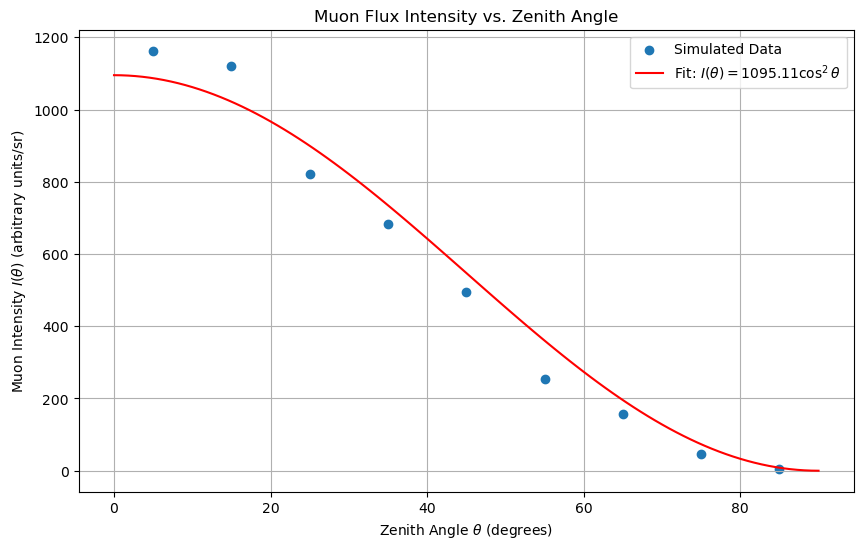

In [15]:
# plotting the graph
plt.figure(figsize=(10, 6))

# Plot the binned data points (flux vs zenith angle)
plt.scatter(bin_centers, flux_intensity, label='Simulated Data')


# generating 100 values from 0 to 90 
theta_range = np.linspace(0, 90, 100)

# fitting the curve with generated data 
fitted_curve = cos_squared_model(theta_range, I0_fit)

#plotting the curve on the same plot as 
plt.plot(theta_range, fitted_curve, 'r-', label=f'Fit: $I(\\theta) = {I0_fit:.2f} \\cos^2\\theta$')

# plotting the graph
plt.title('Muon Flux Intensity vs. Zenith Angle')
plt.xlabel('Zenith Angle $\\theta$ (degrees)')
plt.ylabel('Muon Intensity $I(\\theta)$ (arbitrary units/sr)')
plt.legend()
plt.grid(True)
plt.show()

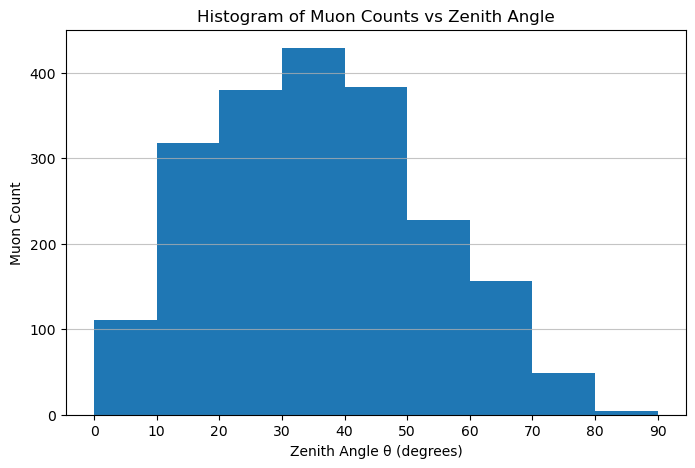

In [16]:

plt.figure(figsize=(8,5))
plt.hist(df['theta'], bins)
plt.xlabel('Zenith Angle θ (degrees)')
plt.ylabel('Muon Count')
plt.title('Histogram of Muon Counts vs Zenith Angle')
plt.xticks(bins)  # show bin edges on x-axis
plt.grid(axis='y', alpha=0.75)
plt.show()